In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam

In [2]:
CLASS_NAMES=['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
NUM_CLASSES=4
BASE_TRAIN_DIR="Alzheimer_s Dataset\\train"
BASE_TEST_DIR="Alzheimer_s Dataset\\test"
AUTOTUNE=tf.data.experimental.AUTOTUNE
NR_EPOCHS=50

In [3]:
NUM_IMAGES=[]
for label in CLASS_NAMES:
    dir_name=f"{BASE_TRAIN_DIR}\{label[:-2]}ed"
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [4]:
print("Number of each type of image in our dataset:")
for label in range(4):
    print(f"{CLASS_NAMES[label]}:{NUM_IMAGES[label]}")

Number of each type of image in our dataset:
MildDementia:2650
ModerateDementia:1542
NonDementia:2560
VeryMildDementia:1792


In [6]:

datagen=ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
for image in range(NUM_IMAGES[1]):
    img=load_img(f'Alzheimer_s Dataset\\train\\ModerateDemented\\moderateDem{image}.jpg')
    x=img_to_array(img)
    x=x.reshape((1,)+x.shape)
    i=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='Alzheimer_s Dataset\\train\\ModerateDemented',save_prefix='moderateDem',save_format='jpg'):
        i+=1
        if i>30:
            break

In [8]:
for image in range(NUM_IMAGES[0]):
    img=load_img(f'Alzheimer_s Dataset\\train\\MildDemented\\mildDem{image}.jpg')
    x=img_to_array(img)
    x=x.reshape((1,)+x.shape)
    i=0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='Alzheimer_s Dataset\\train\\MildDemented',save_prefix='mildDem',save_format='jpg'):
        i+=1
        if i>2:
            break

In [5]:
NEW_NUM_IMAGES=[]
for label in CLASS_NAMES:
    dir_name=f"{BASE_TRAIN_DIR}\\{label[:-2]}ed"
    NEW_NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [6]:
print("New dataset with augmented images:")
for label in range(4):

    print(f"{CLASS_NAMES[label]}:{NEW_NUM_IMAGES[label]}")

New dataset with augmented images:
MildDementia:2650
ModerateDementia:1542
NonDementia:2560
VeryMildDementia:1792


In [11]:
train=ImageDataGenerator(rescale=1./255)
test=ImageDataGenerator(rescale=1./255)
val=ImageDataGenerator(rescale=1./255)

In [7]:

train_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='training',
    seed=1000
)

Found 8544 files belonging to 4 classes.
Using 6836 files for training.


In [8]:

val_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TRAIN_DIR,
    validation_split=0.2,
    image_size=(224,224),
    batch_size=32,
    subset='validation',
    seed=1000
)

Found 8544 files belonging to 4 classes.
Using 1708 files for validation.


In [9]:
test_data=tf.keras.preprocessing.image_dataset_from_directory(
    BASE_TEST_DIR,
    image_size=(224,224),
    batch_size=32,
    seed=1000
)

Found 1279 files belonging to 4 classes.


In [10]:
train_data.class_names=CLASS_NAMES
val_data.class_names=CLASS_NAMES

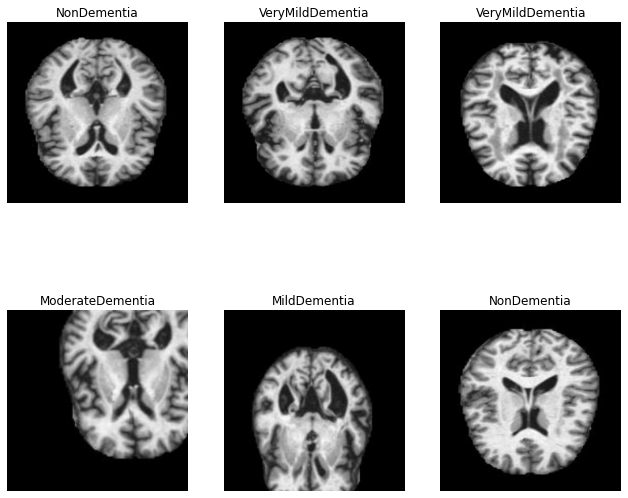

In [11]:
plt.figure(figsize=(11,15))
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]])
        plt.axis("off")
plt.savefig("sample.png")

In [17]:
model = tf.keras.Sequential([
        tf.keras.Input(shape=(224,224, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 separable_conv2d (Separable  (None, 112, 112, 32)     688       
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 112, 112, 32)     1344      
 leConv2D)                                                       
                                                        

In [19]:
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
                )

In [20]:
model_sum=model.fit(train_data,
                    validation_data=val_data,
                    epochs=NR_EPOCHS)

Epoch 1/50
214/214 [==============================] - 401s 2s/step - loss: 1.0908 - accuracy: 0.5304 - val_loss: 2.9731 - val_accuracy: 0.3056
Epoch 2/50
214/214 [==============================] - 378s 2s/step - loss: 0.7503 - accuracy: 0.6473 - val_loss: 2.1401 - val_accuracy: 0.3056
Epoch 3/50
214/214 [==============================] - 379s 2s/step - loss: 0.5045 - accuracy: 0.7659 - val_loss: 0.5354 - val_accuracy: 0.7594
Epoch 4/50
214/214 [==============================] - 377s 2s/step - loss: 0.3754 - accuracy: 0.8340 - val_loss: 0.3651 - val_accuracy: 0.8279
Epoch 5/50
214/214 [==============================] - 377s 2s/step - loss: 0.2589 - accuracy: 0.8945 - val_loss: 0.3783 - val_accuracy: 0.8326
Epoch 6/50
214/214 [==============================] - 380s 2s/step - loss: 0.1856 - accuracy: 0.9299 - val_loss: 0.8005 - val_accuracy: 0.7693
Epoch 7/50
214/214 [==============================] - 394s 2s/step - loss: 0.1552 - accuracy: 0.9432 - val_loss: 0.4130 - val_accuracy: 0.8431

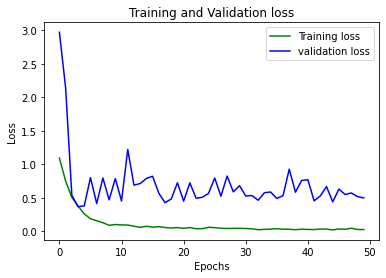

In [21]:
loss_train = model_sum.history['loss']
loss_val = model_sum.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("train_vs_val_loss.png")
plt.show()

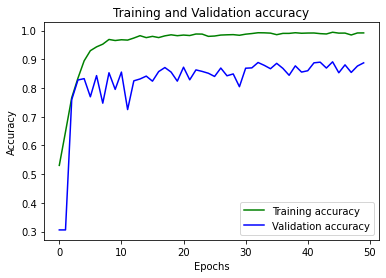

In [22]:
accuracy_train = model_sum.history['accuracy']
accuracy_val = model_sum.history['val_accuracy']
plt.plot(accuracy_train, 'g', label='Training accuracy')
plt.plot(accuracy_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("train_vs_val_acc.png")
plt.show()

In [ ]:
model.evaluate(test_data)

In [24]:
model.save("alzheimer_model.h5")

In [ ]:
file_path='Alzheimer_s Dataset\\test\\ModerateDemented\\27 (2).jpg'
image=tf.keras.preprocessing.image.load_img(file_path)
image=tf.image.resize(image,(224,224))
input_array=tf.keras.preprocessing.image.img_to_array(image)
input_array=np.array([input_array])
pred=model.predict(input_array)
res=np.argmax(pred)
re1=CLASS_NAMES[res]

In [2]:
from tensorflow.keras.models import load_model

new_moddel=load_model("alzheimer_model.h5")

In [14]:
file_path='Alzheimer_s Dataset\\test\\NonDemented\\28 (93).jpg'
image=tf.keras.preprocessing.image.load_img(file_path)
image=tf.image.resize(image,(224,224))
input_array=tf.keras.preprocessing.image.img_to_array(image)
input_array=np.array([input_array])
pred=new_moddel.predict(input_array)
res=np.argmax(pred)
re1=CLASS_NAMES[res]
print(re1)


1/1 [==============================] - 0s 40ms/step
NonDementia
